In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import pandas as pd

train_data = r"C:\Users\Integ\OneDrive\Desktop\ML_Stuff\ML_Code\DATA\Training - Copy\Training"

## first set the image and batch size
batch = 32

## now set up data augmentation 

data_augment = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(128, scale=(0.99, 1.01)),
        transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# Loading datasets
full_dataset = datasets.ImageFolder(train_data, transform=data_augment['train'])
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False)
num_classes = len(full_dataset.classes)


### Create a class for the model why? idk

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(next(model.parameters()).device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training loop
epochs = 50
metrics = {'train_loss': [], 'train_acc': [], 'val_loss': [],'val_acc': []}

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    correct_train_predictions = 0   # <-- Added this line
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        
        _, predicted = outputs.max(1)
        correct_train_predictions += predicted.eq(labels).sum().item()  # <-- Added this line
        
        loss.backward()
        optimizer.step()

    train_acc = 100 * correct_train_predictions  / len(train_loader.dataset)
    avg_train_loss = total_train_loss / len(train_loader)
    metrics['train_acc'].append(train_acc)
    metrics['train_loss'].append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * correct / total
        metrics['val_acc'].append(val_accuracy)
        metrics['val_loss'].append(avg_val_loss)

print(f'Epoch: {epoch+1}, Train Acc: {metrics["train_acc"][49]}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {100.*correct/total:.2f}%')

cuda:0
Epoch: 50, Train Loss: 0.6403, Val Loss: 0.5548, Val Acc: 78.62%


In [99]:
## Testing the model
from torchvision import transforms
from torchvision.datasets import ImageFolder


testing_data = r"C:\Users\Integ\OneDrive\Desktop\ML_Stuff\ML_Code\DATA\Testing - Copy\Testing"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to the size expected by your model
    transforms.ToTensor()
])

testing_dataset = ImageFolder(root=testing_data, transform=transform)

batch_size = 32  # or your defined value
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)  # It's typical to not shuffle test data


# Set the model to evaluation mode
model.eval()

# Initialize metrics
test_loss = 0.0
correct = 0
total = 0

# No gradient calculations during testing/validation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100. * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.5137, Test Accuracy: 79.86%


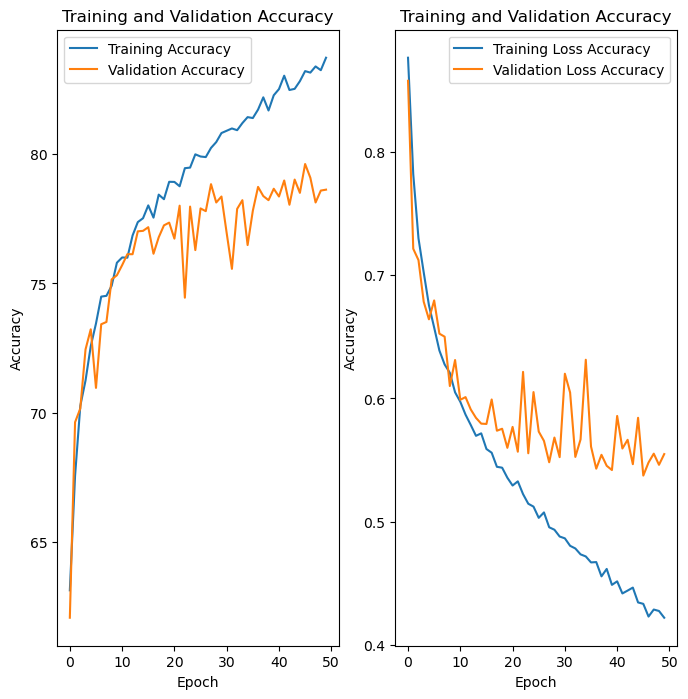

In [100]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, metrics['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, metrics['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, metrics['train_loss'], label='Training Loss Accuracy')
plt.plot(epochs_range, metrics['val_loss'], label='Validation Loss Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
